## Data Analysis and Visualization of Child-Related Crimes in 2022 in Los Angeles County


### import necessary libraries 

In [3]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
import pymongo
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from sklearn.cluster import KMeans

## MongoDB Connection Setup

In [5]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["crime_data"]  # Creating database
collection = db["child_related_crimes_2022"]  # Creating a collection

In [6]:
# Deleting all documents in the collection to avoid repetation 
collection.delete_many({})  
print("All records in the collection have been deleted.")

All records in the collection have been deleted.


## extract the data from XML to MongoDB

In [8]:
#Reloading the data from XML File
file_path = "response.xml"

# Parsing the XML content here
tree = ET.parse(file_path)
root = tree.getroot()

# Defining the fields to extract
fields = [
    'dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name', 'rpt_dist_no',
    'part_1_2', 'crm_cd', 'crm_cd_desc', 'mocodes', 'vict_age', 'vict_sex', 'vict_descent',
    'premis_cd', 'premis_desc', 'weapon_used_cd', 'weapon_desc', 'status', 'status_desc',
    'crm_cd_1', 'location', 'lat', 'lon'
]

# Extracting the data dynamically using the above mentioned feilds
data_list = []
for row in root.findall('.//row'):
    data = {field: row.find(field).text if row.find(field) is not None else None for field in fields}
    data_list.append(data)

# now we will insert the data into MongoDB
if data_list:
    collection.insert_many(data_list)
    print(f"Inserted {len(data_list)} records into MongoDB.")
else:
    print("No data found in the XML file.")

# checking the data in MongoDB collection after inserting
print(f"Total records in the collection after insertion: {collection.count_documents({})}")

Inserted 1699 records into MongoDB.
Total records in the collection after insertion: 1699


## fetching records from MongoDB and saving the data to CSV file

In [10]:
# now we will fetch all records from MongoDB
cursor = collection.find()
data_list = list(cursor)  # Converting cursor to a list of dictionaries with this

# Removing MongoDB's default '_id' field here
for record in data_list:
    if "_id" in record:
        del record["_id"]

# Converting list of dictionaries into DataFrame
df = pd.DataFrame(data_list)

# validating that the dataframe is not empty
if df.empty:
    raise ValueError("The DataFrame is empty. No data was fetched from MongoDB.")


# Saving the data to CSV file
csv_file_path = "child_related_crimes_2022.csv"  
df.to_csv(csv_file_path, index=False)

#Confirming the file creation and exception handeling 
if os.path.exists(csv_file_path):
    print(f"Data successfully extracted and saved to '{csv_file_path}'")
else:
    raise IOError(f"Failed to save CSV file at '{csv_file_path}'")


Data successfully extracted and saved to 'child_related_crimes_2022.csv'


## data charecteristics of the data 

In [12]:
# Loading the CSV file
csv_file_path = "child_related_crimes_2022.csv" 
df = pd.read_csv(csv_file_path)

#checing the dataframe info
df.info()

# Checking for the missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Checking the data types
print("\nData Types:")
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dr_no           1698 non-null   float64
 1   date_rptd       1698 non-null   object 
 2   date_occ        1698 non-null   object 
 3   time_occ        1698 non-null   float64
 4   area            1698 non-null   float64
 5   area_name       1698 non-null   object 
 6   rpt_dist_no     1698 non-null   float64
 7   part_1_2        1698 non-null   float64
 8   crm_cd          1698 non-null   float64
 9   crm_cd_desc     1698 non-null   object 
 10  mocodes         1667 non-null   object 
 11  vict_age        1698 non-null   float64
 12  vict_sex        1698 non-null   object 
 13  vict_descent    1698 non-null   object 
 14  premis_cd       1698 non-null   float64
 15  premis_desc     1698 non-null   object 
 16  weapon_used_cd  1093 non-null   float64
 17  weapon_desc     1093 non-null   o

### formating the data


In [14]:
# Converting the 'date' columns to datetime
date_columns = ['date_rptd', 'date_occ']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Converting the numeric columns to appropriate types
numeric_columns = ['vict_age', 'lat', 'lon']
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')


## Cleaning the data 

In [16]:
# Removing the leading or trailing whitespace in string columns with this 
string_columns = ['area_name', 'crm_cd_desc', 'vict_sex', 'vict_descent', 'status_desc']
for col in string_columns:
    if col in df.columns:
        df[col] = df[col].str.strip()

# Standardizing the text case for categorical columns
categorical_columns = ['vict_sex', 'vict_descent', 'status_desc']
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].str.upper()

# Removing the garbage value 'H' from the 'vict_sex' column
if 'vict_sex' in df.columns:
    df = df[df['vict_sex'] != 'H']

# Handling missing values
# Droping the rows where important columns are missing
critical_columns = ['crm_cd', 'date_rptd']
df = df.dropna(subset=critical_columns)

# Filling the missing numeric values with the median in victim age 
if 'vict_age' in df.columns:
    df['vict_age'] = df['vict_age'].fillna(df['vict_age'].median())

# 4. now saving the cleaned data in a new csv file
cleaned_csv_path = "child_related_crimes_2022_cleaned.csv"
df.to_csv(cleaned_csv_path, index=False)

print(f"\nCleaned data saved to '{cleaned_csv_path}'")


Cleaned data saved to 'child_related_crimes_2022_cleaned.csv'


# Visualizations of the data 

In [18]:
# Loading the cleaned data
csv_file_path = "child_related_crimes_2022_cleaned.csv"
df = pd.read_csv(csv_file_path)

#checking the info 
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697 entries, 0 to 1696
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dr_no           1697 non-null   float64
 1   date_rptd       1697 non-null   object 
 2   date_occ        1697 non-null   object 
 3   time_occ        1697 non-null   float64
 4   area            1697 non-null   float64
 5   area_name       1697 non-null   object 
 6   rpt_dist_no     1697 non-null   float64
 7   part_1_2        1697 non-null   float64
 8   crm_cd          1697 non-null   float64
 9   crm_cd_desc     1697 non-null   object 
 10  mocodes         1666 non-null   object 
 11  vict_age        1697 non-null   float64
 12  vict_sex        1697 non-null   object 
 13  vict_descent    1697 non-null   object 
 14  premis_cd       1697 non-null   float64
 15  premis_desc     1697 non-null   object 
 16  weapon_used_cd  1092 non-null   float64
 17  weapon_desc     1092 non-null   o

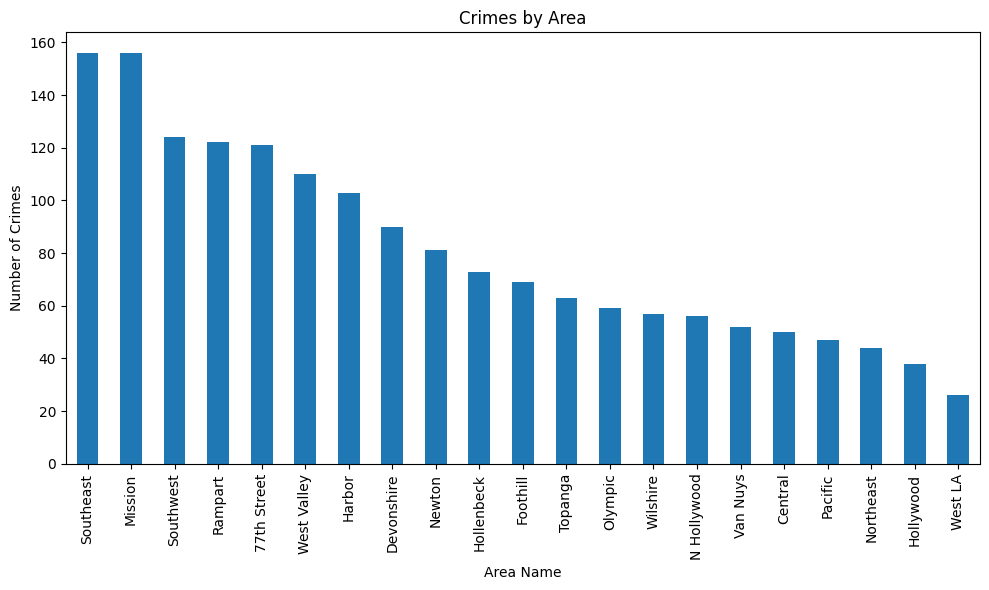

In [19]:
# Visulizations of general overview

# Count of the crimes by area
crimes_by_area = df['area_name'].value_counts()
plt.figure(figsize=(10, 6))
crimes_by_area.plot(kind='bar', title='Crimes by Area')
plt.xlabel('Area Name')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

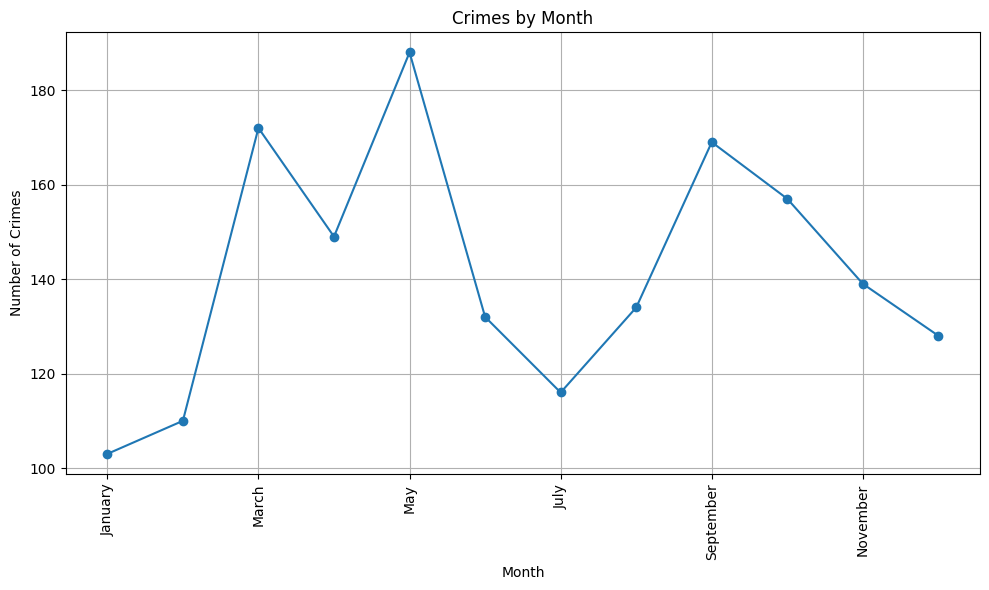

In [20]:
#Time based Analysis

# replacing the month number with month names
df['month_name'] = pd.to_datetime(df['date_rptd']).dt.strftime('%B')
crimes_by_month_name = df['month_name'].value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Crimes by Month
plt.figure(figsize=(10, 6))
crimes_by_month_name.plot(kind='line', marker='o', title='Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

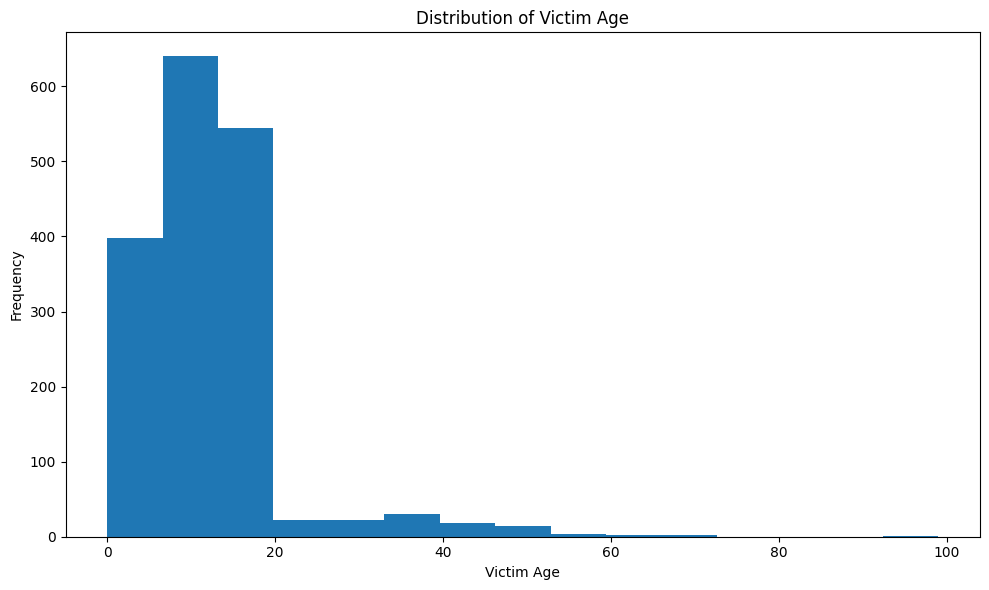

In [21]:
# checking the victim age distribution

plt.figure(figsize=(10, 6))
df['vict_age'].dropna().plot(kind='hist', bins=15, title='Distribution of Victim Age')
plt.xlabel('Victim Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

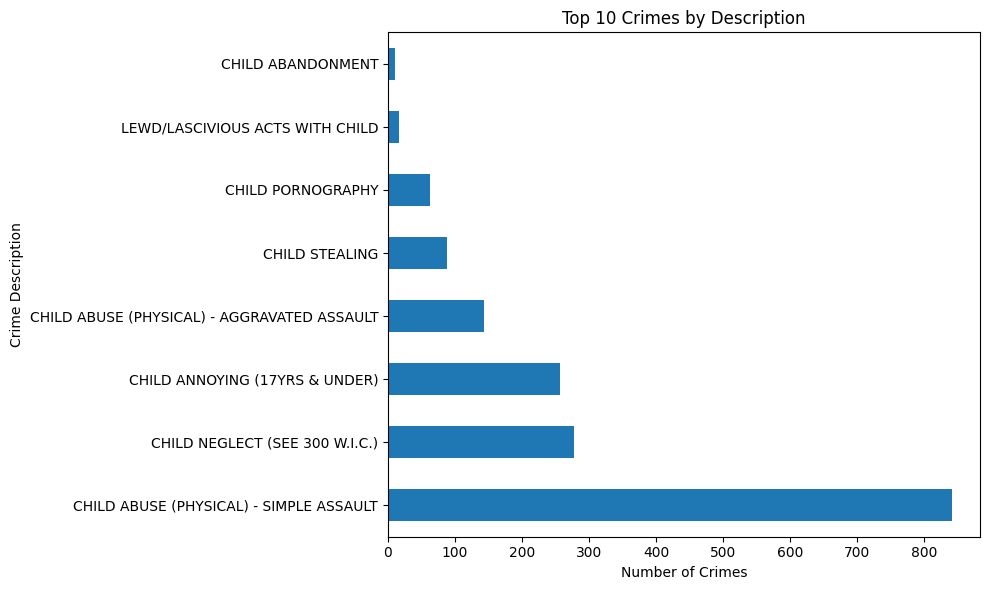

In [22]:
# checking crimes by the crime description
# Count of the crimes by description
crimes_by_description = df['crm_cd_desc'].value_counts()

plt.figure(figsize=(10, 6))
crimes_by_description.head(10).plot(kind='barh', title='Top 10 Crimes by Description')
plt.xlabel('Number of Crimes')
plt.ylabel('Crime Description')
plt.tight_layout()
plt.show()

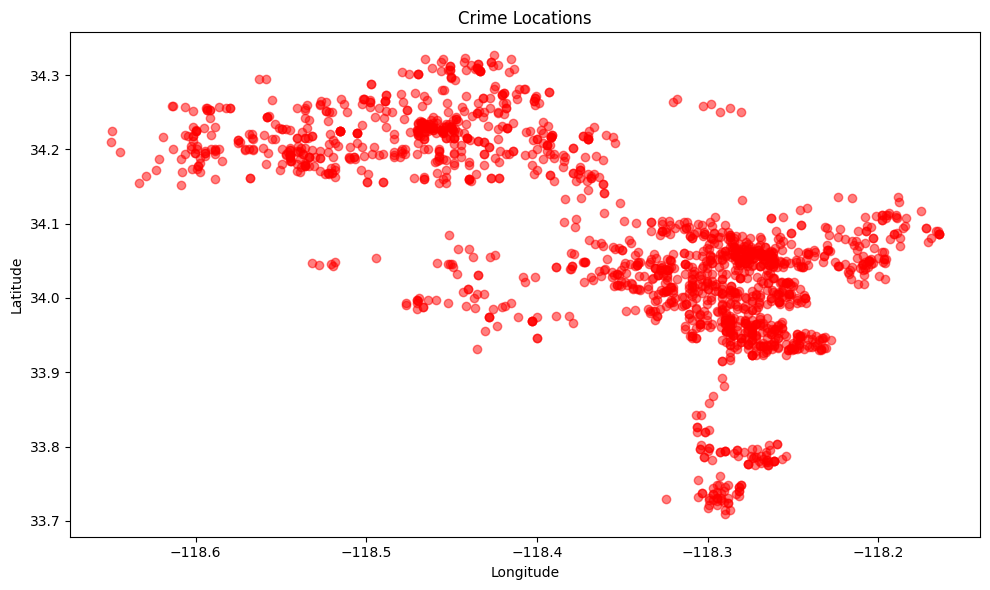

In [23]:
# creating a location scatter plot

plt.figure(figsize=(10, 6))
plt.scatter(df['lon'], df['lat'], alpha=0.5, color='red')
plt.title('Crime Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

In [24]:
# visulaizing a interactive map for all the crime locations using folium

# Creating a folium map on Los Angeles
crime_map_all_locations = folium.Map(location=[34.0522, -118.2437], zoom_start=10)

# Adding markers for all the locations in the our dataset
for _, row in df.iterrows():
    if not pd.isnull(row['lat']) and not pd.isnull(row['lon']):
        folium.CircleMarker(
            location=(row['lat'], row['lon']),
            radius=3,
            color='red',
            fill=True,
            fill_color='white',
            fill_opacity=0.6,
            popup=f"{row['crm_cd_desc']}, {row['date_rptd']}"
        ).add_to(crime_map_all_locations)

# Saving the map as HTML
crime_map_all_locations.save("crime_map_all_locations.html")
print("Crime map for all locations saved as 'crime_map_all_locations.html'")

crime_map_all_locations

Crime map for all locations saved as 'crime_map_all_locations.html'


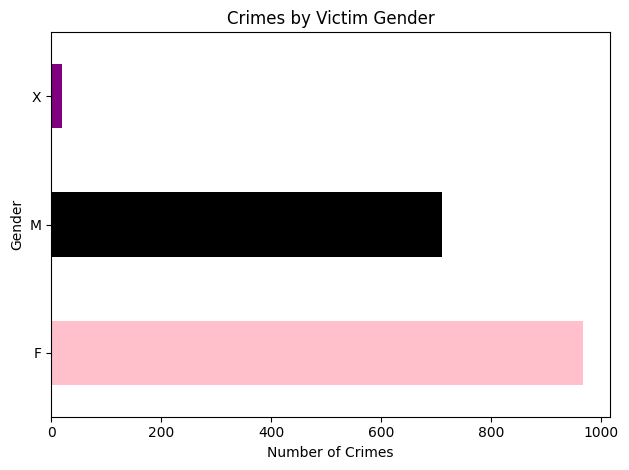

In [25]:
#checking the crimes based on victim gender to see any connection 

victim_gender_dist = df['vict_sex'].value_counts()
colors = ['pink', 'black', 'purple']  
victim_gender_dist.plot(kind='barh', title='Crimes by Victim Gender', color=colors)
plt.xlabel('Number of Crimes')
plt.ylabel('Gender')
plt.tight_layout()
plt.show()

In [26]:

# now creating a heatmap for crime locations to check high crime areas 

heatmap_map = folium.Map(location=[34.0522, -118.2437], zoom_start=10)
heatmap_data = df[['lat', 'lon']].dropna().values.tolist()
HeatMap(heatmap_data).add_to(heatmap_map)
heatmap_map.save("crime_heatmap.html")
print("Heatmap saved as 'crime_heatmap.html'")
heatmap_map

Heatmap saved as 'crime_heatmap.html'


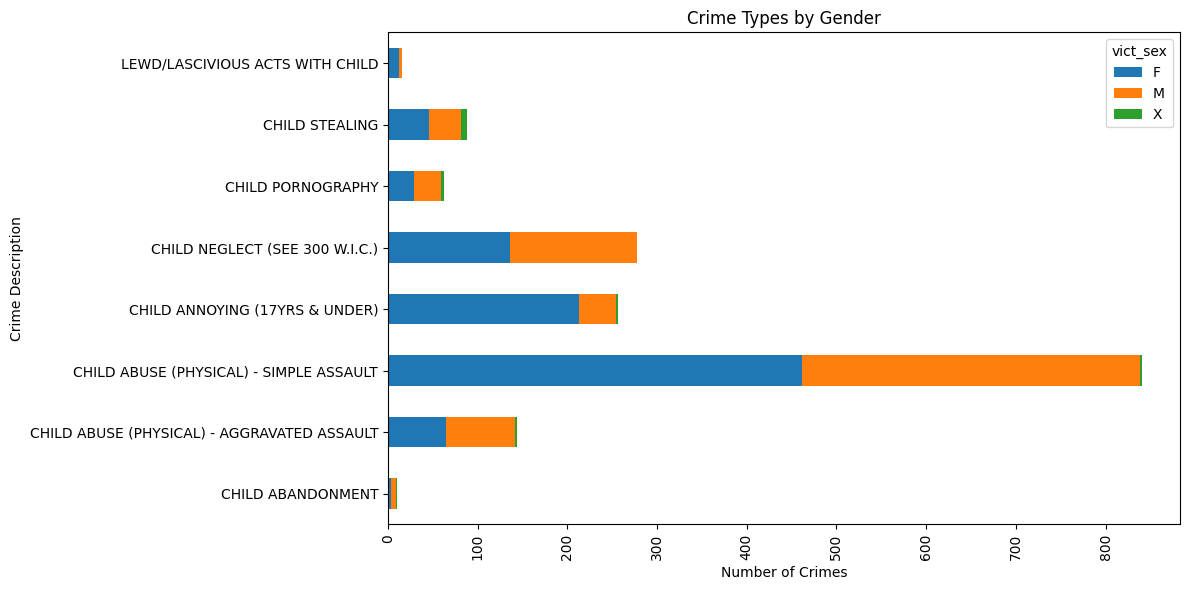

In [27]:
# now checking each crime type based on gender 

crime_gender_pivot = df.pivot_table(index='crm_cd_desc', columns='vict_sex', aggfunc='size', fill_value=0)
crime_gender_pivot.head(10).plot(kind='barh', stacked=True, figsize=(12, 6), title='Crime Types by Gender')
plt.ylabel('Crime Description')
plt.xlabel('Number of Crimes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Applying KMeans clustering to cluster the locations and classify them based on crime density 

In [29]:
#Preprocessing the data

# just making sure the rows with missing coordinates are dropped
df = df.dropna(subset=['lat', 'lon'])

# Clustering the locations using KMeans
n_clusters = 60  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[['lat', 'lon']])

# Now classify the clusters based on crime density
cluster_crime_density = df['Cluster'].value_counts().sort_index()
thresholds = {
    'safe': cluster_crime_density.quantile(0.2),        # bottom 20% is safe
    'moderately_safe': cluster_crime_density.quantile(0.8),  # middle 60% is moderately safe
}

# Assigning the safety zones
def classify_density(count):
    if count <= thresholds['safe']:
        return 'safe'
    elif count <= thresholds['moderately_safe']:
        return 'moderately_safe'
    else:
        return 'dangerous'

df['Safety'] = df['Cluster'].map(cluster_crime_density).apply(classify_density)

#Visualizing it on map
# now we will create a folium map centered on the average location
safety_map = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=10)

# defining colors for safety zones
safety_colors = {
    'safe': 'green',
    'moderately_safe': 'yellow',
    'dangerous': 'red'
}

# Adding cluster centers with safety zones to the map
for cluster in range(n_clusters):
    cluster_data = df[df['Cluster'] == cluster]
    safety = cluster_data['Safety'].iloc[0]  # all of the rows in the same cluster have the same safety level
    folium.CircleMarker(
        location=[cluster_data['lat'].mean(), cluster_data['lon'].mean()],
        radius=10,
        color=safety_colors[safety],
        fill=True,
        fill_color=safety_colors[safety],
        fill_opacity=0.6,
        popup=f"Cluster {cluster}: {safety.capitalize()} Zone<br>Crime Count: {len(cluster_data)}"
    ).add_to(safety_map)

# Saving the map
safety_map.save("safety_zones_map.html")
print("Safety zones map is saved as 'safety_zones_map.html'")

#will display here too
safety_map

Safety zones map is saved as 'safety_zones_map.html'
